In [1]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np



from resnetpass import resnet18_cbam

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [3]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
model = resnet18_cbam(pretrained=False)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [6]:
model.fc = nn.Linear(512,512)

In [7]:
!pwd

/home/ubuntu/lialib/colab


In [8]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [9]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [10]:
class_order

tensor([30, 43, 94, 73, 34, 67, 62, 33, 61, 15, 78, 28, 41, 68, 57,  0,  3, 22,
         5,  2, 65, 26, 54, 32, 24, 83, 72, 13, 29, 49, 98, 20, 31, 82, 71, 44,
        42, 91, 40, 99, 23, 97,  6, 90, 45, 63, 60, 56, 87, 47, 79, 51, 58, 17,
        16, 96, 52, 75, 92, 69, 35, 38, 53, 25,  1, 80, 39, 88, 21, 74, 36, 19,
        11, 10, 76, 89, 59, 37,  9, 14, 81, 95, 77, 64, 70, 46, 55, 66, 86, 85,
        18, 12,  7, 48, 93,  4, 27,  8, 50, 84])

In [11]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [12]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [14]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [15]:
set_test.shape

(5000,)

In [16]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [17]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [18]:
x,y = next(iter(dl_train))

In [19]:
y.shape

torch.Size([64])

In [20]:
y

tensor([ 3, 94,  6, 45, 31, 97, 56, 65, 83, 41, 32, 87, 28, 42, 61, 15, 13,  3,
        63, 65, 15, 47, 29, 68, 29, 22, 94, 82, 56, 24, 47, 65, 24, 60, 33,  5,
        40, 40, 67, 13, 94, 24, 44, 72, 20, 90, 72, 97, 56, 61,  5, 41,  0, 78,
        13, 13, 44, 94, 63, 41, 61, 90, 97, 22])

In [21]:
from pytorch_metric_learning import losses
loss_func = losses.ArcFaceLoss(num_classes=100,embedding_size=512)


In [22]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [25]:
import wandb

In [26]:
config = {
    "surrounding":True
}

In [27]:
wandb.init(
    # set the wandb project where this run will be logged
    project="clip+dmil",
    config=config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edson-matsubara (lablia). Use `wandb login --relogin` to force relogin


In [30]:

opt = optim.Adam(model.parameters(),lr=0.001)

In [31]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [32]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [33]:
emb_batch = model(x.to(device))

In [34]:
from sklearn.manifold import TSNE

In [35]:
# given a batch of instances create a surrounding sample of instances
def create_surrounding_batch(batch,batch_y, num_surrounding=100, size=0.001):
    surrounding_batch = []
    surrounding_batch_y = []
    for i in range(len(batch)):
        
        instances_sorrounding = batch[i]+(torch.randn(num_surrounding,512)*size).to(batch.device)
        surrounding_batch.append(instances_sorrounding)
        surrounding_batch_y.append(batch_y[i].repeat(num_surrounding))
    return torch.cat(surrounding_batch), torch.cat(surrounding_batch_y)

In [36]:
batch_emb, batch_y = create_surrounding_batch(emb_batch,y)

In [37]:
batch_emb.shape

torch.Size([6400, 512])

In [38]:
batch_y.shape

torch.Size([6400])

In [39]:

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.003s...
[t-SNE] Computed neighbors for 6400 samples in 0.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.252884
[t-SNE] KL divergence after 1000 iterations: 0.935422


In [40]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [41]:
def tsne_proj(batch_emb, batch_y):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())
    cmap = cm.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(15,15))
    num_categories = 100
    for lab in range(num_categories):
        if lab in batch_y:
            indices = batch_y==lab
            ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.003s...
[t-SNE] Computed neighbors for 6400 samples in 0.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.225994
[t-SNE] KL divergence after 1000 iterations: 0.932839


/tmp/ipykernel_142844/3286734825.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


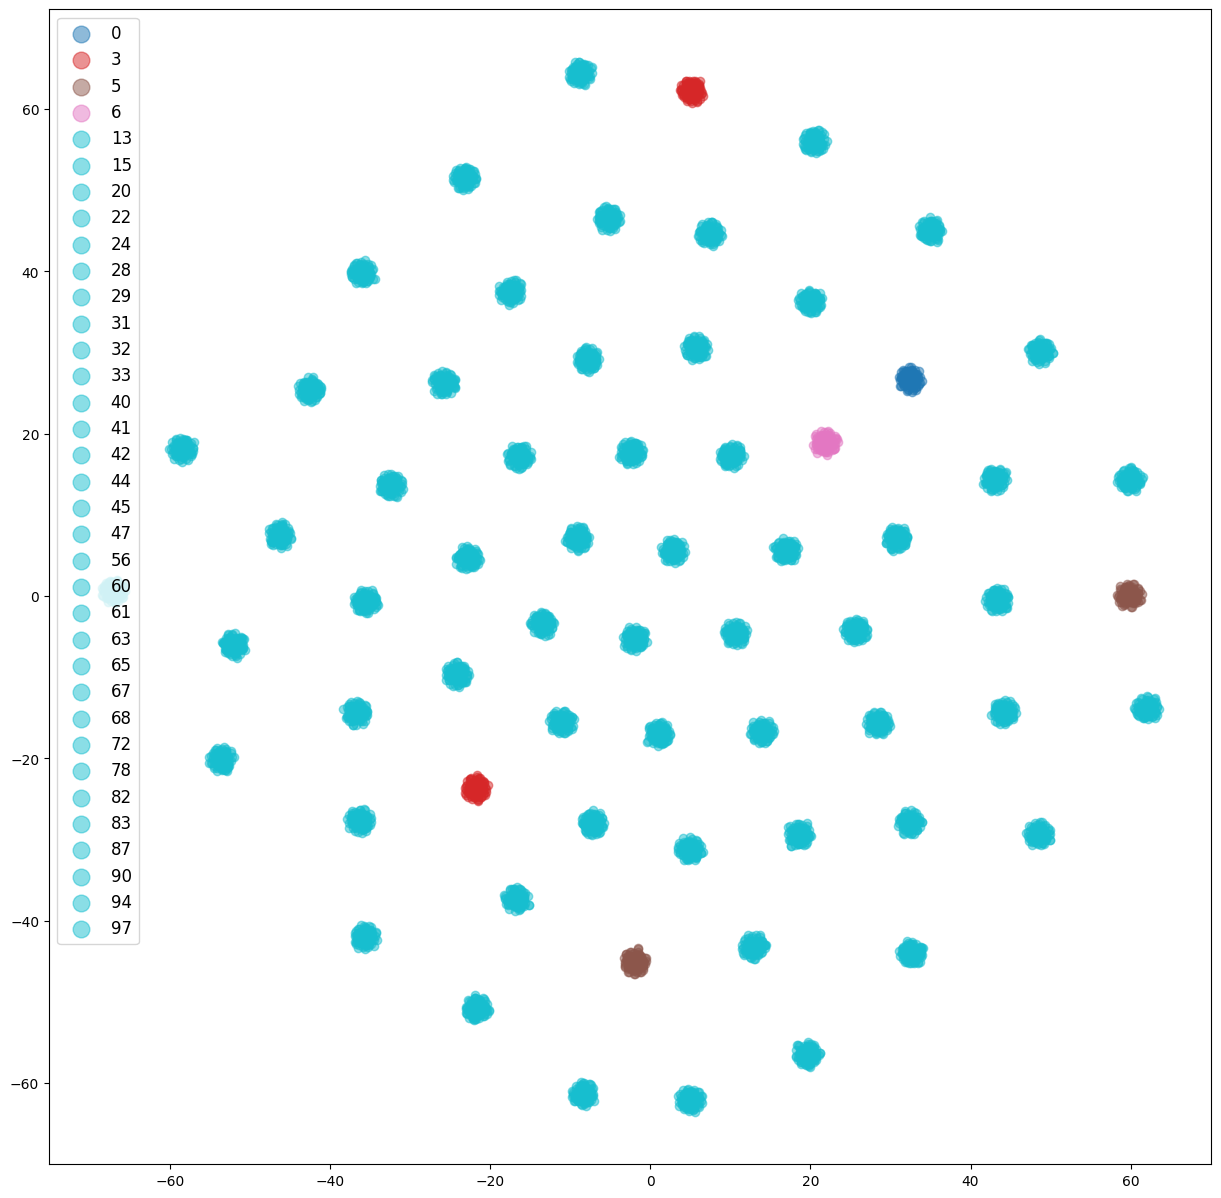

In [42]:
tsne_proj(batch_emb,batch_y)

In [43]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [44]:
import sklearn.neighbors as neighbors

In [45]:
from sklearn.metrics import classification_report

In [46]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=1,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [47]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

100%|██████████| 5/5 [00:00<00:00, 53.08it/s]


In [48]:
pred.shape,test_y.T.shape

((300,), (300,))

In [49]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       0.12      0.20      0.15         5
           2       0.00      0.00      0.00         7
           3       0.13      0.40      0.20        10
           5       0.25      0.20      0.22         5
           6       0.06      0.12      0.08         8
          13       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         5
          20       0.00      0.00      0.00         7
          22       0.00      0.00      0.00         8
          23       0.57      0.44      0.50         9
          24       0.20      0.67      0.31         3
          26       0.00      0.00      0.00         8
          28       0.00      0.00      0.00         6
          29       0.00      0.00      0.00         7
          30       0.22      0.25      0.24         8
          31       0.11      0.12      0.12         8
          32       0.00      0.00      0.00         5
          33       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
import sklearn.metrics as metrics

In [51]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        #batch_emb, batch_y = create_surrounding_batch(embeddings,labels)
        loss = loss_func(embeddings, labels)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,labels = pred_knn_model(model,dl_sub_train,dl_sub_test)
        f1 = metrics.f1_score(labels,pred,average='macro')
        precision = metrics.precision_score(labels,pred,average='macro')
        recall = metrics.recall_score(labels,pred,average='macro')
        accuracy = metrics.accuracy_score(labels,pred)
        wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
        print(classification_report(labels.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]},step=epoch)

100%|██████████| 5/5 [00:00<00:00, 50.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.14      0.20      0.17         5
           2       0.10      0.14      0.12         7
           3       0.07      0.10      0.08        10
           5       0.00      0.00      0.00         5
           6       0.27      0.38      0.32         8
          13       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         5
          20       0.67      0.29      0.40         7
          22       0.00      0.00      0.00         8
          23       0.60      0.33      0.43         9
          24       0.50      1.00      0.67         3
          26       0.00      0.00      0.00         8
          28       0.33      0.17      0.22         6
          29       0.00      0.00      0.00         7
          30       0.42      0.62      0.50         8
          31       0.18      0.25      0.21         8
          32       0.20      0.20      0.20         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.56it/s]


loss 32.0874431932064


100%|██████████| 391/391 [00:17<00:00, 22.50it/s]


loss 29.968711653024034


100%|██████████| 391/391 [00:17<00:00, 22.54it/s]


loss 27.3340832254161


100%|██████████| 391/391 [00:17<00:00, 22.57it/s]


loss 24.390298004345517


100%|██████████| 391/391 [00:17<00:00, 22.72it/s]


loss 21.286923015818875


100%|██████████| 391/391 [00:17<00:00, 22.72it/s]


loss 18.10862755104709


100%|██████████| 391/391 [00:17<00:00, 22.65it/s]


loss 14.893055603632233


100%|██████████| 391/391 [00:17<00:00, 22.58it/s]


loss 11.718341839587902


100%|██████████| 391/391 [00:17<00:00, 22.60it/s]


loss 8.799209620336743


100%|██████████| 5/5 [00:00<00:00, 59.11it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       1.00      0.14      0.25         7
           3       0.38      0.80      0.52        10
           5       1.00      0.60      0.75         5
           6       1.00      0.75      0.86         8
          13       1.00      0.67      0.80         3
          15       1.00      0.20      0.33         5
          20       1.00      0.57      0.73         7
          22       0.50      0.62      0.56         8
          23       1.00      0.56      0.71         9
          24       0.60      1.00      0.75         3
          26       0.71      0.62      0.67         8
          28       1.00      1.00      1.00         6
          29       1.00      0.86      0.92         7
          30       0.55      0.75      0.63         8
          31       0.83      0.62      0.71         8
          32       0.12      0.20      0.15         5
          33       0.50    

100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


loss 3.9960883076843396


100%|██████████| 391/391 [00:17<00:00, 22.66it/s]


loss 2.5949658322364777


100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


loss 1.785125861844748


100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


loss 1.553470971334316


100%|██████████| 391/391 [00:17<00:00, 22.64it/s]


loss 1.2031682366981644


100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


loss 1.035032691429262


100%|██████████| 391/391 [00:17<00:00, 22.95it/s]


loss 0.9336142995635338


100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


loss 0.9817963670748655


100%|██████████| 391/391 [00:17<00:00, 22.91it/s]


loss 0.9072338452448359


100%|██████████| 5/5 [00:00<00:00, 59.62it/s]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           2       0.67      0.29      0.40         7
           3       1.00      0.60      0.75        10
           5       1.00      0.20      0.33         5
           6       0.86      0.75      0.80         8
          13       1.00      0.33      0.50         3
          15       0.33      0.20      0.25         5
          20       1.00      0.71      0.83         7
          22       0.71      0.62      0.67         8
          23       0.73      0.89      0.80         9
          24       0.75      1.00      0.86         3
          26       0.75      0.38      0.50         8
          28       0.86      1.00      0.92         6
          29       1.00      0.57      0.73         7
          30       0.60      0.75      0.67         8
          31       0.50      0.75      0.60         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


loss 0.7275156628392885


100%|██████████| 391/391 [00:17<00:00, 22.90it/s]


loss 0.7243167243997954


100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


loss 0.7043168081680451


100%|██████████| 391/391 [00:17<00:00, 22.81it/s]


loss 0.6277011334592395


100%|██████████| 391/391 [00:17<00:00, 22.83it/s]


loss 0.576544906766585


100%|██████████| 391/391 [00:17<00:00, 22.66it/s]


loss 0.5429010489863841


100%|██████████| 391/391 [00:17<00:00, 22.85it/s]


loss 0.5898205803527409


100%|██████████| 391/391 [00:17<00:00, 22.89it/s]


loss 0.5968791893242723


100%|██████████| 391/391 [00:17<00:00, 22.90it/s]


loss 0.5379592279749958


100%|██████████| 5/5 [00:00<00:00, 58.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           2       0.67      0.29      0.40         7
           3       0.86      0.60      0.71        10
           5       0.67      0.40      0.50         5
           6       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         3
          15       1.00      0.40      0.57         5
          20       1.00      0.71      0.83         7
          22       0.56      0.62      0.59         8
          23       0.80      0.44      0.57         9
          24       1.00      1.00      1.00         3
          26       0.80      0.50      0.62         8
          28       1.00      1.00      1.00         6
          29       1.00      0.57      0.73         7
          30       0.86      0.75      0.80         8
          31       0.57      0.50      0.53         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.91it/s]


loss 0.5118035865581982


100%|██████████| 391/391 [00:17<00:00, 22.82it/s]


loss 0.5027053419380303


100%|██████████| 391/391 [00:17<00:00, 22.76it/s]


loss 0.38346275839927224


100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


loss 0.56887845594979


100%|██████████| 391/391 [00:17<00:00, 22.95it/s]


loss 0.3821956565528584


100%|██████████| 391/391 [00:17<00:00, 22.88it/s]


loss 0.44244443353466795


100%|██████████| 391/391 [00:17<00:00, 22.85it/s]


loss 0.4304292992664301


100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


loss 0.3937228388359051


100%|██████████| 391/391 [00:17<00:00, 22.73it/s]


loss 0.37884653307964355


100%|██████████| 5/5 [00:00<00:00, 60.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.67      0.29      0.40         7
           3       0.29      0.60      0.39        10
           5       1.00      0.60      0.75         5
           6       1.00      0.75      0.86         8
          13       1.00      0.33      0.50         3
          15       0.50      0.60      0.55         5
          20       1.00      0.71      0.83         7
          22       0.75      0.75      0.75         8
          23       1.00      0.56      0.71         9
          24       1.00      1.00      1.00         3
          26       1.00      0.62      0.77         8
          28       1.00      1.00      1.00         6
          29       1.00      0.57      0.73         7
          30       0.86      0.75      0.80         8
          31       0.43      0.38      0.40         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


loss 0.38806522448721065


100%|██████████| 391/391 [00:17<00:00, 22.83it/s]


loss 0.396180815103016


100%|██████████| 391/391 [00:17<00:00, 22.76it/s]


loss 0.3762740483763568


100%|██████████| 391/391 [00:17<00:00, 22.56it/s]


loss 0.33101334558029316


100%|██████████| 391/391 [00:17<00:00, 22.63it/s]


loss 0.14873286279256615


100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


loss 0.05978855649363655


100%|██████████| 391/391 [00:17<00:00, 22.76it/s]


loss 0.043221527293129156


100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


loss 0.03783375277708563


100%|██████████| 391/391 [00:17<00:00, 22.88it/s]


loss 0.03138620100999989


100%|██████████| 5/5 [00:00<00:00, 60.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.33      0.14      0.20         7
           3       0.83      0.50      0.62        10
           5       1.00      0.40      0.57         5
           6       1.00      0.75      0.86         8
          13       1.00      0.67      0.80         3
          15       0.25      0.40      0.31         5
          20       1.00      0.71      0.83         7
          22       0.83      0.62      0.71         8
          23       1.00      0.44      0.62         9
          24       1.00      1.00      1.00         3
          26       1.00      0.50      0.67         8
          28       1.00      0.83      0.91         6
          29       1.00      0.14      0.25         7
          30       0.88      0.88      0.88         8
          31       0.75      0.38      0.50         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.62it/s]


loss 0.02739651118779717


100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


loss 0.030892813005699012


100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


loss 0.026005417903494615


100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


loss 0.022899752873403338


100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


loss 0.023067709181860893


100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


loss 0.02397457061974389


100%|██████████| 391/391 [00:17<00:00, 22.82it/s]


loss 0.022009161442977942


100%|██████████| 391/391 [00:17<00:00, 22.83it/s]


loss 0.023087916270870826


100%|██████████| 391/391 [00:17<00:00, 22.90it/s]


loss 0.023043729328548018


100%|██████████| 5/5 [00:00<00:00, 59.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.50      0.14      0.22         7
           3       0.70      0.70      0.70        10
           5       1.00      0.20      0.33         5
           6       0.86      0.75      0.80         8
          13       1.00      1.00      1.00         3
          15       0.50      0.20      0.29         5
          20       1.00      0.71      0.83         7
          22       1.00      0.62      0.77         8
          23       1.00      0.56      0.71         9
          24       1.00      1.00      1.00         3
          26       0.75      0.38      0.50         8
          28       1.00      1.00      1.00         6
          29       1.00      0.43      0.60         7
          30       0.86      0.75      0.80         8
          31       0.75      0.38      0.50         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


loss 0.01874021475028861


100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


loss 0.019089117554737533


100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


loss 0.01670313922754165


100%|██████████| 391/391 [00:17<00:00, 22.83it/s]


loss 0.018661356506073642


100%|██████████| 391/391 [00:17<00:00, 22.87it/s]


loss 0.017788143312904504


100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


loss 0.0149844779056566


100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


loss 0.019831138381036593


100%|██████████| 391/391 [00:17<00:00, 22.84it/s]


loss 0.013753624591048058


100%|██████████| 391/391 [00:17<00:00, 22.69it/s]


loss 0.014469888921894962


100%|██████████| 5/5 [00:00<00:00, 60.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.67      0.29      0.40         7
           3       0.08      0.80      0.15        10
           5       1.00      0.20      0.33         5
           6       0.75      0.75      0.75         8
          13       1.00      1.00      1.00         3
          15       0.33      0.20      0.25         5
          20       1.00      0.57      0.73         7
          22       0.86      0.75      0.80         8
          23       0.83      0.56      0.67         9
          24       1.00      1.00      1.00         3
          26       1.00      0.38      0.55         8
          28       1.00      1.00      1.00         6
          29       1.00      0.43      0.60         7
          30       0.78      0.88      0.82         8
          31       0.67      0.50      0.57         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.72it/s]


loss 0.012151312225622117


100%|██████████| 391/391 [00:17<00:00, 22.70it/s]


loss 0.012132301622101932


100%|██████████| 391/391 [00:17<00:00, 22.76it/s]


loss 0.017268708160119082


100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


loss 0.011919541257198976


100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


loss 0.013317542547947201


100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


loss 0.013251941896888102


100%|██████████| 391/391 [00:17<00:00, 22.92it/s]


loss 0.012774574627969985


100%|██████████| 391/391 [00:17<00:00, 22.93it/s]


loss 0.014543934083973056


100%|██████████| 391/391 [00:16<00:00, 23.01it/s]


loss 0.014824423047936047


100%|██████████| 5/5 [00:00<00:00, 60.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.50      0.14      0.22         7
           3       0.75      0.60      0.67        10
           5       1.00      0.20      0.33         5
           6       0.86      0.75      0.80         8
          13       1.00      0.67      0.80         3
          15       0.25      0.20      0.22         5
          20       1.00      0.57      0.73         7
          22       0.71      0.62      0.67         8
          23       1.00      0.56      0.71         9
          24       1.00      1.00      1.00         3
          26       1.00      0.38      0.55         8
          28       1.00      1.00      1.00         6
          29       1.00      0.43      0.60         7
          30       0.86      0.75      0.80         8
          31       0.60      0.38      0.46         8
          32       0.00      0.00      0.00         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.98it/s]


loss 0.013385635291826447


100%|██████████| 391/391 [00:17<00:00, 22.82it/s]


loss 0.011619382917739885


100%|██████████| 391/391 [00:17<00:00, 22.97it/s]


loss 0.012203843404953976


100%|██████████| 391/391 [00:17<00:00, 22.90it/s]


loss 0.01433294645772325


100%|██████████| 391/391 [00:17<00:00, 22.92it/s]


loss 0.014622237006186858


100%|██████████| 391/391 [00:17<00:00, 22.84it/s]


loss 0.015049703803661938


100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


loss 0.01564856468575716


100%|██████████| 391/391 [00:17<00:00, 22.89it/s]


loss 0.015663689383945148


100%|██████████| 391/391 [00:17<00:00, 22.85it/s]


loss 0.01502166267233136


100%|██████████| 5/5 [00:00<00:00, 54.22it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.50      0.14      0.22         7
           3       0.71      0.50      0.59        10
           5       1.00      0.40      0.57         5
           6       0.75      0.75      0.75         8
          13       1.00      0.67      0.80         3
          15       0.33      0.20      0.25         5
          20       1.00      0.71      0.83         7
          22       0.83      0.62      0.71         8
          23       0.80      0.44      0.57         9
          24       1.00      1.00      1.00         3
          26       1.00      0.38      0.55         8
          28       1.00      0.83      0.91         6
          29       1.00      0.57      0.73         7
          30       0.86      0.75      0.80         8
          31       0.75      0.38      0.50         8
          32       0.50      0.20      0.29         5
          33       1.00    

100%|██████████| 391/391 [00:17<00:00, 22.73it/s]


loss 0.014970674796257397


100%|██████████| 391/391 [00:17<00:00, 22.58it/s]


loss 0.012553465924129877


100%|██████████| 391/391 [00:17<00:00, 22.78it/s]


loss 0.012507164843387597


100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


loss 0.013101369190616939


100%|██████████| 391/391 [00:17<00:00, 22.70it/s]


loss 0.013598645486764115


100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


loss 0.01191622276018258


100%|██████████| 391/391 [00:17<00:00, 22.78it/s]


loss 0.011618531507435742


100%|██████████| 391/391 [00:17<00:00, 22.89it/s]


loss 0.011543303175651899


100%|██████████| 391/391 [00:17<00:00, 22.69it/s]

loss 0.011211737741322001


In [52]:
epoch

99

In [59]:
pred,labels = pred_knn_model(model,dl_train,dl_test)

100%|██████████| 79/79 [00:01<00:00, 48.89it/s]


In [60]:
f1 = metrics.f1_score(labels,pred,average='macro')
precision = metrics.precision_score(labels,pred,average='macro')
recall = metrics.recall_score(labels,pred,average='macro')
accuracy = metrics.accuracy_score(labels,pred)

In [61]:
print(f"precision {precision}")
print(f"recall {recall}")
print(f"f1 {f1}")
print(f"accuracy {accuracy}")

precision 0.6830182030393689
recall 0.6268
f1 0.6424953925940154
accuracy 0.6268


precision 0.6781332025178556
recall 0.6264
f1 0.6407966031823693
accuracy 0.6264

In [56]:
wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
print(classification_report(labels.T,pred))

              precision    recall  f1-score   support

           0       0.16      0.86      0.27       100
           2       0.56      0.55      0.55       100
           3       0.44      0.39      0.41       100
           5       0.75      0.57      0.65       100
           6       0.68      0.62      0.65       100
          13       0.84      0.63      0.72       100
          15       0.36      0.50      0.42       100
          20       0.90      0.79      0.84       100
          22       0.60      0.58      0.59       100
          23       0.70      0.70      0.70       100
          24       0.91      0.79      0.84       100
          26       0.61      0.54      0.57       100
          28       0.90      0.74      0.81       100
          29       0.66      0.57      0.61       100
          30       0.69      0.65      0.67       100
          31       0.75      0.49      0.59       100
          32       0.60      0.50      0.54       100
          33       0.64    

In [57]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [58]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train},'rn18_dml_pass_100epochs.pth')

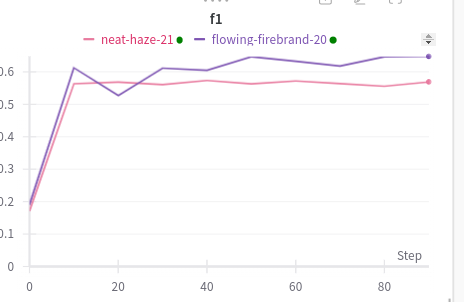

- neat sem a proposta
- flowing com a proposta 